## **Segundo avance del proyecto, tecnicas de inteligencia artificial**

### **Integrantes**

- Oscar Leonardo Riveros Perez

- Yovany Esneider Vargas Gutierrez

**Preproceso, adecuación de imagenes**

In [16]:
import cv2
from IPython.display import Image
import os
import numpy as np
import math
from matplotlib import pyplot as plt
import time

#Se tienen 3 tipos de imagen
#Mano al interior
Indoor_P = cv2.imread('Images/Indoor_P.jpg',1)
Indoor_G = cv2.imread('Images/Indoor_G.jpg',1)

#Mano al exterior pero con un patron de ladrillos de fondo
Pattern_P = cv2.imread('Images/Pattern_P.jpg',1)
Pattern_G = cv2.imread('Images/Pattern_G.jpg',1)

#Mano en un ambiente donde hay varios tipos de objetos
Green_P = cv2.imread('Images/Green_P.jpg',1)
Green_G = cv2.imread('Images/Green_G.jpg',1)

#[:,:,::-1] -> Correccion para representar con matplotlib, ya que el arreglo de opencv esta en [B,G,R] y matplotlib [R,G,B]
Green_P, Green_G, Indoor_P, Indoor_G, Pattern_P, Pattern_G = Green_P[:,:,::-1],Green_G[:,:,::-1], Indoor_P[:,:,::-1], Indoor_G[:,:,::-1], Pattern_P[:,:,::-1], Pattern_G[:,:,::-1]

Original_P = [Indoor_P, Pattern_P, Green_P]
Original_G = [Indoor_G, Pattern_G, Green_G]

***Tecnicas de Segmentacion***

La primera etapa para realizar un procesamiento adecuado de la mano, consiste en la segmentacion de la imagen para obtener la region donde se encuentra el objeto a identificar, en este caso las manos.

****Espacios de Color + Otsu****

Uno de los primeros planteamientos sobre la segmentacion de la mano corresponde al analisis en los diferentes espacios de color para encontrar el metodo con el mejor desempeño.

Los espacios de color más son compatibles con el reconocimiento de piel son el HSV y YCrCb. Sin embargo, en un estudio realizado por Michael J. Jones, demuestra que son más relavantes el numero de bins que el espacio de color utilizado en el reconocimiento de la piel, por tanto, también se pondrá a prueba este metodo.

In [ ]:
#Funciones
def YCrCb(img):
    return (cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))

def HSV(img):
    return (cv2.cvtColor(img, cv2.COLOR_RGB2HSV))

def lessBins(img, bins):
    q = 256/bins
    normalized_img = cv2.normalize(img, None, 0, bins-1, cv2.NORM_MINMAX)
    return(normalized_img)

def dilarode(img, kernel):
    dilated_img = cv2.dilate(img, kernel, iterations = 1)
    dilaroded_img = cv2.erode(dilated_img, kernel, iterations = 1)
    return(dilaroded_img)

In [ ]:
#Espacios de color
Manos_YCrCb = [YCrCb(Indoor_P), YCrCb(Pattern_P), YCrCb(Green_P)]
Manos_HSV = [HSV(Indoor_P), HSV(Pattern_P), HSV(Green_P)] 

#Reducción de bins
bins_0 = 128
Manos_128bins = [lessBins(Indoor_P, bins_0), lessBins(Pattern_P, bins_0), lessBins(Green_P, bins_0)]
bins_1 = 16
Manos_64bins = [lessBins(Indoor_P, bins_1), lessBins(Pattern_P, bins_1), lessBins(Green_P, bins_1)]

res = [Manos_YCrCb, Manos_HSV, Manos_128bins, Manos_64bins]
title1 = ['YCrCb ', 'HSV ', '128 Bins ', '32 Bins ']
title2 = ['Indoor', 'Pattern', 'Green']

plt.figure(1)
plt.subplot(5,3,1), plt.imshow(Original_P[0]), plt.title('Original ' + title2[0])
plt.subplot(5,3,2), plt.imshow(Original_P[1]), plt.title('Original ' + title2[1])
plt.subplot(5,3,3), plt.imshow(Original_P[2]), plt.title('Original ' + title2[2])
bins = 256
c = 0
Exec_Time=[]
for i in range(4):
    for j in range(3):
        if i == 2:
            bins = bins_0
        elif i == 3:
            bins = bins_1
        #Se suavisa el histograma para eliminar minimos locales
        blur = cv2.GaussianBlur(res[i][j], (3,3), 0)
        img = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
        #La mano será un máximo global, para garantizar su aparición se usa umbral binario
        ref=time.time()
        tre, otsu = cv2.threshold(img,0,bins-1,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        Exec_Time.append((time.time()-ref)*1e3)
        #print(tre)
        plt.subplot(5,3,c+4), plt.imshow(otsu, cmap=plt.cm.gray), plt.title(title1[i] + title2[j])
        c += 1
Exec_Time_mean=sum(Exec_Time) / len(Exec_Time)
print("El tiempo de ejecucion del umbral Otsu es de: "+str(Exec_Time_mean)+"ms")
plt.subplots_adjust(top=3, bottom=0.5, left=0.0, right=0.8, hspace=0.5, wspace=0.5)
plt.show()

Aunque hay ventajas en los interiores con en el espacio de color HSV y en exteriores con YCrCb con respecto a la reducción en el número de bins, esta última mantiene un balance en todos los casos, evidenciando lo descrito por Michael J. Jones en su estudio en la detección de piel en imágenes.

****Espacios de Color - Rango de color****

Uno de los metodos comunmente utilizados para realizar la segmentacion de la mano consiste en la segmentacion por umbralizacion del espacio de color, para esto se ha de tener en cuenta que para definir los limites de umbral se utilizas el espacio de color HSV de modo que se tiene en cuenta el tono de piel se encuentra cercano para un valor de HUE entre [0,20]. 

In [ ]:

title1 = 'HSV '
title2 = ['Indoor', 'Pattern', 'Green']

plt.figure(1)
plt.subplot(5,3,1), plt.imshow(Original_P[0]), plt.title('Original ' + title2[0])
plt.subplot(5,3,2), plt.imshow(Original_P[1]), plt.title('Original ' + title2[1])
plt.subplot(5,3,3), plt.imshow(Original_P[2]), plt.title('Original ' + title2[2])
bins = 256
c = 0
lower_skin = np.array([0,20,70], dtype=np.uint8)
upper_skin = np.array([20,255,255], dtype=np.uint8)
Exec_Time=[]

for j in range(3):

    #Se suavisa el histograma para eliminar minimos locales
    blur = cv2.GaussianBlur(Manos_HSV[j], (3,3), 0)

    #La mano será un máximo global, para garantizar su aparición se usa umbral binario
    ref=time.time()
    mask = cv2.inRange(blur, lower_skin, upper_skin)
    Exec_Time.append((time.time()-ref)*1e3)

    #print(tre)
    plt.subplot(5,3,c+4), plt.imshow(mask, cmap=plt.cm.gray), plt.title(title1 + title2[j])
    c += 1

Exec_Time_mean=sum(Exec_Time) / len(Exec_Time)
print("El tiempo de ejecucion del umbral Otsu es de: "+str(Exec_Time_mean)+"ms")
plt.subplots_adjust(top=3, bottom=0.5, left=0.0, right=0.8, hspace=0.5, wspace=0.5)
plt.show()

Como se puede observar en el entorno de exteriores el umbral de la mano esta bien definido, mas sin embargo cuando el entorno entra dentro del umbral de color definido, no se realiza una umbralizacion correctamente, por ende de manera general no es un buen resultado a diferencia de la umbralizacion de otsu realizado en diferentes espacios de color.

****Super Pixeles - SLIC****

Otro metodo que se plantea para realizar la semgnentacion corresponde a la generacion de clusteres aleatorios que agrupen caracteristicas similares de pixeles vecinos, esto con la finalidad de agrupar los pixeles que conforman la mano cuyas caracteristicas son muy similares entre si.

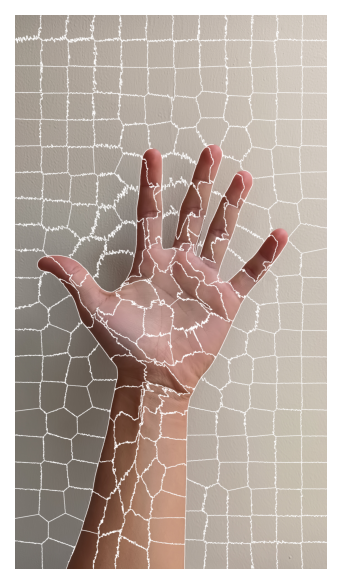

In [22]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util         import img_as_float

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

segments=slic(Indoor_P, n_segments=250,compactness=10,sigma=0)

fig=plt.figure("superpixels-- %d segments"%(250))
ax = fig.add_subplot(1,1,1)
ax.imshow(mark_boundaries(Indoor_P,segments,color=(1,1,1),outline_color=(1,1,1)))

plt.axis("off")
plt.show()

In [ ]:
#Se suavisa el histograma para eliminar minimos locales
blur = cv2.GaussianBlur(HSV(Indoor_G), (5,5), 0)
img = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

#Debido a que buscan los maximos globales lo mejor es usar umbral binario
tre, otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#Se aplica dilatación erosión
kernel = np.ones((5, 5), np.uint8)
dilaroded_img = dilarode(otsu, kernel)

#AND entre la segmentación y la imagen original
merged = cv2.bitwise_and(Indoor_G, Indoor_G, mask=dilaroded_img)
merged_gray = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)

#Hallar sombras
_, shadows = cv2.threshold(merged_gray,60,255,cv2.THRESH_TOZERO_INV)

#Hallar Canny
canny = cv2.Canny(merged_gray,40,255)
canny_dilated = cv2.dilate(canny, kernel, iterations = 1)

#AND entre sombras y canny
merged_edge = cv2.bitwise_and(canny, canny_dilated, mask = shadows)
merged_dilated = cv2.dilate(merged_edge, kernel, iterations = 1)

#Hallar fronteras
contour, _ = cv2.findContours(merged_gray, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.drawContours(np.zeros_like(merged_gray), contour, -1, (255), 2)
contour_dilated = cv2.dilate(contour_image, kernel, iterations = 1)

#Silueta final
final_merged = cv2.bitwise_or(contour_image, merged_dilated)
final_dilated = cv2.dilate(final_merged, kernel, iterations = 1)

plt.figure(1)
plt.subplot(3,3,1), plt.imshow(Indoor_G), plt.title('Original ' + title2[0])
plt.subplot(3,3,2), plt.imshow(otsu, cmap=plt.cm.gray), plt.title('HSV ' + title2[0])
plt.subplot(3,3,3), plt.imshow(merged_gray, cmap=plt.cm.gray), plt.title('Original filtered')
plt.subplot(3,3,4), plt.imshow(shadows, cmap=plt.cm.gray), plt.title('Threshold Shadow')
plt.subplot(3,3,5), plt.imshow(canny_dilated, cmap=plt.cm.gray), plt.title('Canny edge')
plt.subplot(3,3,6), plt.imshow(merged_dilated, cmap=plt.cm.gray), plt.title('Merged')
plt.subplot(3,3,7), plt.imshow(contour_dilated, cmap=plt.cm.gray), plt.title('Contour')
plt.subplot(3,3,8), plt.imshow(final_dilated, cmap=plt.cm.gray), plt.title('Final edge')
plt.subplots_adjust(top=2.7, bottom=0.5, left=0.0, right=1.0, hspace=0.0, wspace=0.5)
plt.show()

Con la silueta completa de la mano, lo siguiente es hallar la estructura de los dedos, en otras palabras identificar los dedos. Esto mediante una mascara que me elimina los contornos y dibuja en sus extremos.

In [ ]:
#Máscara de 7x7 hay que se expande N veces, donde N es una cuarta parte del grosor del dedo
def generator(N):
    d = 1+ 3*N
    matriz = np.zeros((d,d))
    center = 3*N
    matriz[center][center] = -1
    
    for i in range(d):
        for j in range(d):
            radio = np.sqrt((i - center)**2 + (j - center)**2)
            if radio <= N:
                matriz[i, j] = -1
            elif radio > N and radio <= 2*N or radio > 2.3*N:
                matriz[i, j] = 0
            else:
                matriz[i, j] = 1
    G = []
    matriz = matriz.tolist()
    for i in range(d):
        a = matriz[i]
        b = matriz[i][::-1][1:]
        G.append(a + b)
    for i in range(d-1):
        G.append(G[d-2-i])
    return(G)

final_edge = cv2.bitwise_and(Indoor_G, Indoor_G, mask=final_dilated)

#Convolución con G
G = np.array(generator(50))
fingers = cv2.filter2D(final_edge, -1, G)

#Erosión para eliminar areas no deseadas
k = np.ones((61, 61), np.uint8)
fingers = cv2.erode(fingers, k, iterations = 1)

#Encontrar los dedos usando el valor del umbral obtenido por Otsu en el espacio de colo HSV
mask = cv2.cvtColor(fingers, cv2.COLOR_BGR2GRAY)
manoSeg = cv2.bitwise_and(Indoor_G, Indoor_G, mask=mask)
hsv_gray = cv2.cvtColor(HSV(manoSeg), cv2.COLOR_BGR2GRAY)
_ ,Mano_Binary = cv2.threshold(hsv_gray,88,255,cv2.THRESH_BINARY)

#Se dilatan las areas para mayor visualización
k = np.ones((12, 12), np.uint8)
Mano_Binary_dilated = cv2.dilate(Mano_Binary,k, iterations = 1)

#Se unen el contorno y la detección de los dedos
FINAL = cv2.bitwise_or(Mano_Binary_dilated, final_dilated)

plt.figure(1)
plt.subplot(1,3,1), plt.imshow(fingers), plt.title('Final Edge * G')
plt.subplot(1,3,2), plt.imshow(manoSeg), plt.title('Mask AND Original')
plt.subplot(1,3,3), plt.imshow(FINAL, cmap=plt.cm.gray), plt.title('Final feature')
plt.subplots_adjust(top=2, bottom=0.0, left=0.0, right=1.3, hspace=0, wspace=0.25)
plt.show()

Con el contorno de la mano hallado y la identificación de los dedos, ya es posible la caraterización de la mano y los gestos en tiempo real. Lo cual se expondra en una demo en el segundo avance del proyecto.

### **Referencias**

[1] Y. Zhou, G. Jiang, and Y. Lin. A novel finger and hand pose estimation technique for real-time hand gesture re- cognition. Pattern Recognition, 49:102–114, 2016. doi: 10.1016/j.patcog.2015.07.014.

[2] M.J. Jones, J.M. Rehg, Statistical color models with application to skin detection, in: IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 1999.